In [1]:
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook, tqdm
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.stats import pearsonr, spearmanr
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates

### Load epi data

In [2]:
ds_path="/mlodata1/prakhar/all_available_tweets_piped"
files = [f for f in  sorted(os.listdir(ds_path)) if f[-4:] != '.txt']
piped_dates = [f.split('_')[1].split('.')[0] for f in files]

# Nb. of tweets per day for normalization
day_flux_path = '/mlodata1/prakhar/twitter_covid_insights/insights_All/day_flux.pkl'
day_flux = pkl.load(open(day_flux_path, 'rb'))

# Read counts
trends_path = '/mlodata1/prakhar/twitter_covid_insights/insights_All/trends.pkl'
trends = pkl.load(open(trends_path, 'rb'))[0]

# Read epi for US
epi_df = pd.read_csv('../Data/epi_data.csv')
epi_df = epi_df[epi_df.iso_code == 'USA']
country_dates = epi_df['date'].values

# Overlapping Dates
dates = set(piped_dates[110:]) & set(country_dates)
trends_to_keep = [True if d in dates else False for d in piped_dates[110:]]

# Normalize trends, drop 110 first for stability
for key in trends :
    trends[key] = (trends[key] / day_flux)[110:][trends_to_keep]
    trends[key] /= trends[key].sum()
    
# Create polarized trends
for e in range(int(len(trends) / 3)) :
    trends[f'Pol-{e}'] = trends[f'Pos-{e}'] / (trends[f'Pos-{e}'] + trends[f'Neg-{e}'])
    trends.pop(f'Pos-{e}', None)
    trends.pop(f'Neg-{e}', None)

trends = pd.DataFrame(trends)


to_correlate = ['cases',
                'deaths',
                'recovered',
                'new_cases',
                'mobility_google_index',
                'tests',
                'people_vaccinated',
                'daily_vaccinations']
cols_to_keep = ["date", "iso_code"] + to_correlate

# Load epi df for US with relevant dates
epi_df = epi_df[epi_df.date.isin(dates)].sort_values('date').reset_index(drop=True)

# Normalize counts
epi_df[to_correlate] = epi_df[to_correlate].astype(float) / epi_df[to_correlate].sum(axis=0)

# Remove and display Nan values
#epi_df = epi_df.dropna(axis="columns", thresh = int(0.9*len(epi_df)))
#epi_df.fillna(method='ffill', inplace=True)

# Convert date column to datetime
epi_df['converted_date'] = pd.to_datetime(epi_df['date'], format='%Y-%m-%d')

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-2-6a6f6ada334e>:24: RuntimeWarning: invalid value encountered in true_divide
  trends[key] = (trends[key] / day_flux)[110:][trends_to_keep]


Gaussian Smoothing 

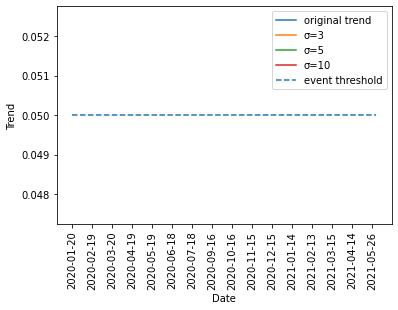

In [3]:
topic_nb = '20'
frequency=30
plt.plot(trends[topic_nb], label='original trend')
plt.plot(gaussian_filter1d(trends[topic_nb], 3), label='\u03C3=3')
plt.plot(gaussian_filter1d(trends[topic_nb], 5), label='\u03C3=5')
plt.plot(gaussian_filter1d(trends[topic_nb], 10), label='\u03C3=10')
plt.hlines(0.05, 0, len(trends[topic_nb]), linestyle='--', label='event threshold')
plt.legend()
plt.xticks(np.arange(len(dates))[::frequency], sorted(dates)[::frequency], rotation=90)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.savefig('gaussian_smoothing.png', dpi=600)
plt.show()

In [4]:
trends

,0,1,2,3,4,5,6,7,8,9,...,Pol-351,Pol-352,Pol-353,Pol-354,Pol-355,Pol-356,Pol-357,Pol-358,Pol-359,Pol-360
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Trends by time

In [31]:
# Find topic ids of the topics that contain the relevant hashtags
hashtags_of_interest = ["#selfcare", "#vaccine", "#protest"]
topic_ids_of_interest = {}
is_pol = np.array(['-' in x for x in trends.columns])
continuous_thresh = 0.05
#topics_path = '/scratch/hartley/twitter_covid_insights/insights_All/topics_700_occ400.pkl'
topics_path = '/scratch/hartley/twitter_covid_insights/insights_All/recomposed_topics.pkl'
topics = pkl.load(open(topics_path, 'rb'))[0]

for topic_name in trends:
    topic_valid = trends[topic_name].notna()
    if '-' in topic_name:
        topic_idx = int(topic_name[4:]) 
        for hashtag in hashtags_of_interest:
            if hashtag in topics[topic_idx]:
                topic_ids_of_interest[hashtag] = topic_idx
                print(f"Name: {topic_name} Topic id: {topic_idx} Hashes:{'-'.join(topics[topic_idx])}\n")

Name: Pol-456 Topic id: 456 Hashes:#selfcare-#yoga-#mindfulness-#meditation

Name: Pol-653 Topic id: 653 Hashes:#protest-#antilockdown-#protesters-#wewillallbethere-#antilockdownprotest

Name: Pol-749 Topic id: 749 Hashes:#vaccine-#covidvaccine-#vaccines-#covid19vaccine-#covidvaccines-#covid19vaccines-#vaccinehesitancy



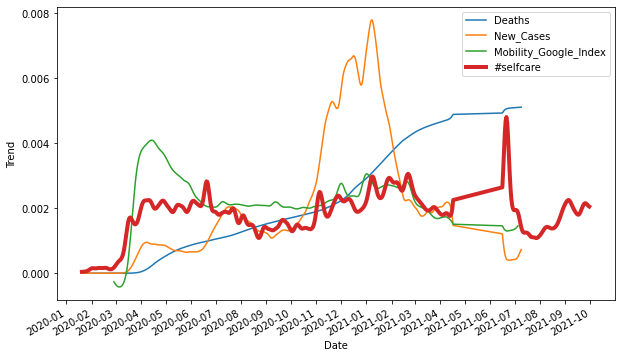

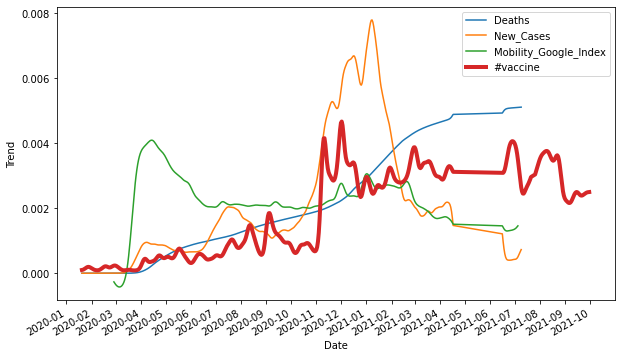

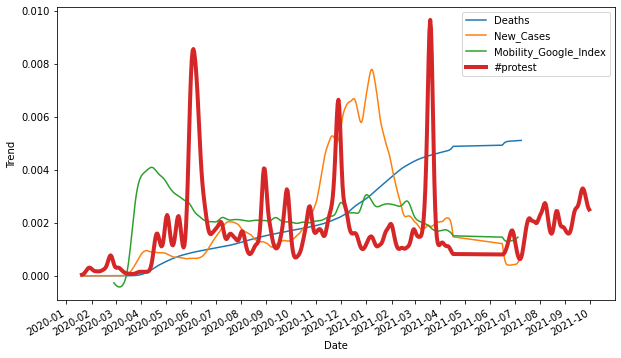

In [32]:
def plot_topic_trend(topic_name: str, gaussian_sigma: int = 3):
    # Plot topic trend alongside epidemiological data.
    topic_id = str(topic_ids_of_interest[topic_name])
    correlated_epi_trends = ["deaths", "new_cases", "mobility_google_index"]
    fig = plt.figure(figsize = (10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    for epi_trend in correlated_epi_trends:
        ax.plot(epi_df['converted_date'], gaussian_filter1d(epi_df[epi_trend], gaussian_sigma), label=epi_trend.title())
    ax.plot(epi_df['converted_date'], gaussian_filter1d(trends[topic_id], gaussian_sigma), label=topic_name, linewidth=4)
    ax.xaxis_date()
    fig.autofmt_xdate()
    plt.xlabel('Date')
    plt.ylabel('Trend')
    plt.legend()

# Plot trends for all hashtags of interest
for hashtag in hashtags_of_interest:
    plot_topic_trend(hashtag)

### Compute correlations

In [34]:
corr_method = 'pearson'
corr_strength = 0.9
continuous_thresh = 0.05
blur = True
report_path = f'{corr_method}_report_{corr_strength}.txt'
country = 'USA'
#topics_path = "/scratch/hartley/twitter_covid_insights/insights_All/topics_700_occ400.pkl"
topics_path = "/scratch/hartley/twitter_covid_insights/insights_All/recomposed_topics.pkl"
topics = pkl.load(open(topics_path, 'rb'))[0]

# Categorize events
is_pol = np.array(['-' in x for x in trends.columns])
peak_events = trends.columns[trends.max(axis=0) > 0.25]
continuous_events = trends.columns[(trends.max(axis=0) < continuous_thresh) | is_pol]
print(f"Correlating {len(continuous_events)} continuous topics")

scores = []
twitter_sigma = 5
epi_sigma = 2

# Compute the correlation
for country_feat in tqdm(to_correlate) :
    country_valid = epi_df[country_feat].notna()

    for topic_name in continuous_events :

        topic_valid = trends[topic_name].notna()
        
        #Focus on time series with more than 100 days to correlate
        if ((country_valid & topic_valid).sum() >100) and ('-' not in topic_name):
            count_values = trends[topic_name].values[country_valid & topic_valid]
            country_values = epi_df[country_feat].values[country_valid & topic_valid]

            if blur :
                count_values = gaussian_filter1d(count_values, twitter_sigma)
                country_values = gaussian_filter1d(country_values, epi_sigma)                

            if corr_method == "spearman" :

                # Spearman
                corr, pvalue = spearmanr(country_values, count_values)
                scores.append((corr, pvalue, topic_name, country_feat))

            elif corr_method == "pearson" :

                # Pearson
                corr, pvalue = pearsonr(country_values, count_values)
                scores.append((corr, pvalue, topic_name, country_feat))


scores = sorted(scores, key = lambda x : x[0])

# Generate correlation report
to_plot = to_correlate
nb_to_plot = 10

strong_corrs = 0
for e, feature in enumerate(to_plot) :

    # Compute specific scores
    feat_scores = [s for s in scores if s[-1]==feature]
    pos_scores = [s for s in feat_scores if s[0] >= corr_strength]
    neg_scores = [s for s in feat_scores[::-1] if s[0] <= -corr_strength]

    strong_corrs += len(neg_scores) + len(pos_scores)

    # Start writing report
    mode = "w" if e == 0 else "a"

    with open(report_path, mode, encoding='utf8') as f :

        if e == 0 :
            f.write('-'*30 + "\n")
            f.write(f"REPORT FOR {country}\n")
            f.write('-'*30 + "\n")

        f.write(f"\n\n{feature}\n".upper())
        f.write(f"Found {len(pos_scores)} strong positive correlations\n")
        f.write(f"Found {len(neg_scores)} strong negative correlations\n\n")

        if len(pos_scores) > 0 :
            f.write(f"Positive correlations :\n")
            for pos in pos_scores :
                topic_idx = int(pos[2]) if '-' not in pos[2] else int(pos[2][4:])
                topic_hashes = "-".join(topics[topic_idx])
                f.write(f"\t{pos[0]:.3}/{pos[1]:.3} : {pos[2]} = {topic_hashes}\n")

        if len(neg_scores) > 0 :
            f.write(f"\nNegative correlations :\n")
            for neg in neg_scores :
                topic_idx = int(neg[2]) if '-' not in neg[2] else int(neg[2][4:])
                topic_hashes = "-".join(topics[topic_idx])
                f.write(f"\t{neg[0]:.3}/{neg[1]:.3} : {neg[2]} = {topic_hashes}\n")


print(f"Found {strong_corrs} strong correlations")
print(f"Report generated successfully at {report_path}")

pkl.dump(scores, open("/scratch/hartley/twitter_covid_insights/insights_All/corr_scores_recomposed.pkl", 'wb'))

  0%|          | 0/8 [00:00<?, ?it/s]

Correlating 2213 continuous topics


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Found 186 strong correlations
Report generated successfully at pearson_report_0.9.txt
